# 3. Fitting diads once you have groups
- Once you have divided your diads into groups based on strengths, you need to tweak the fit parameters for each group
- Then you can loop through all files in a given group and automatically fit the spectra

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.70'

## Specifying filetype, and folder as before

In [30]:
# This specifies what file type your Raman exported in. 
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

## Load in data and fit parameters
- This loads in the dataframes of the fit parameters you saved in the other file, by group
- At this point you select what group you want to fit (batch = 'Weak', 'Medium' or 'Strong'). After running through the entire notebook for one group, come back up here to fit a second group.

In [31]:
## load dataframes and numpy arrays 
np_x = joblib.load('np_x.sav')

# Select the group you want to fit ('Weak', 'Medium', 'Strong')
batch='Medium' # Options are Weak, Medium, Strong

if batch=='Weak':
    GroupN_df=joblib.load('Weak_df.sav')
if batch=='Medium':
    GroupN_df=joblib.load('Medium_df.sav')
if batch=='Strong':
    GroupN_df=joblib.load('Strong_df.sav')

### Now load one file from this group to tweak parameters for

In [32]:
Diad_Files =GroupN_df['filename']
i=0


### Lets plot the diad to have a look at it

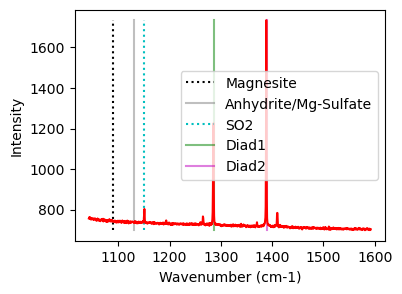

In [33]:
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=filetype)

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

## Choose a model for fitting all peaks
- Option of Voigt or PseudoVoigt. We recomend PsuedoVoigt

In [34]:
model_name='PseudoVoigtModel'

## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [35]:
diad_id_config=pf.diad_id_config(height=50, exclude_range1=[1308, 1309])
diad_id_config

if batch=='Weak':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1250),
    upper_bck_diad1=(1300, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Medium':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240),
    upper_bck_diad1=(1315, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Strong':
    diad1_fit_config_init=pf.diad1_fit_config(
    fit_gauss=True, gauss_amp= 2*GroupN_df['HB1_abs_prom'].iloc[i],
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240), upper_bck_diad1=(1315, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=553.7528359583685, HB_prom=37.50054574136038, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

,Diad1_Combofit_Cent,Diad1_Voigt_Cent,Diad1_cent_err,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Voigt_Gamma,HB1_Cent,HB1_Area,HB1_Sigma,Diad1_Combofit_Height,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit
0,1285.353603,1285.353653,0.00335,899.104347,0.580228,0,1265.205581,86.983346,0.63964,589.621188,2.620155,0.589402,1.160456,Flagged Warnings:


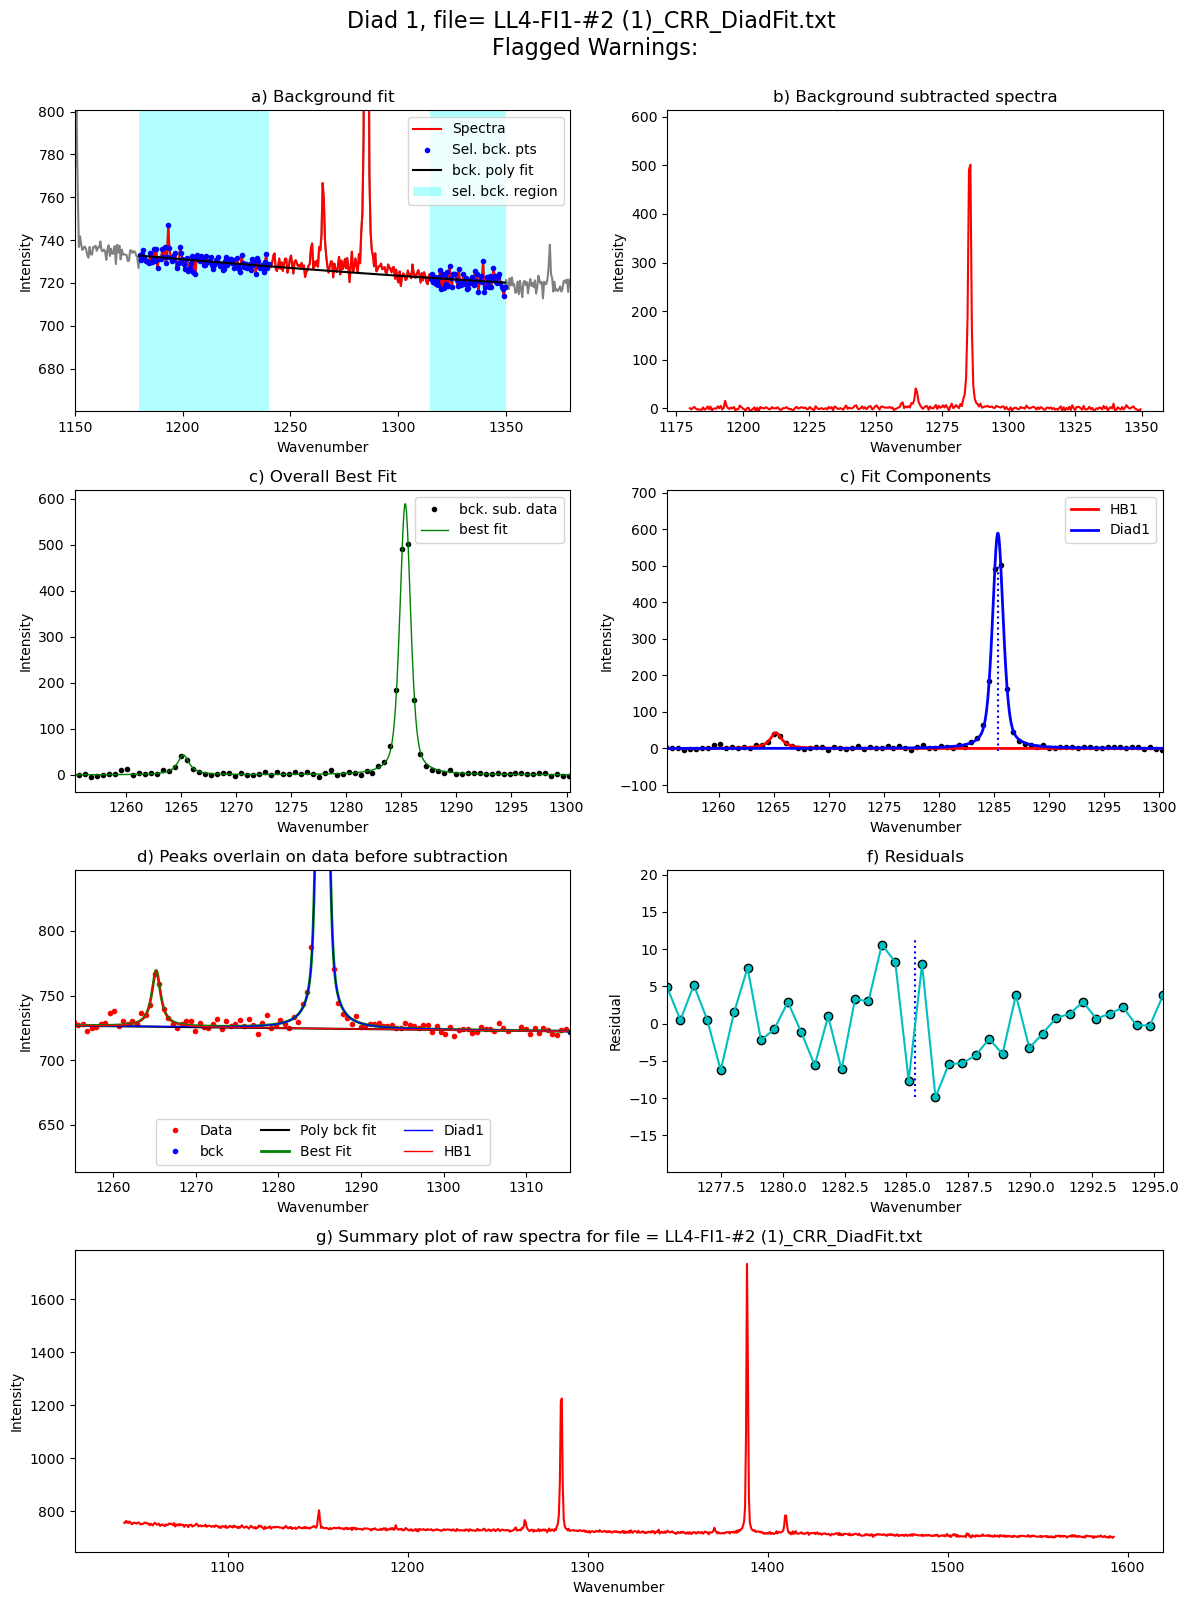

In [36]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=Diad_Files.iloc[0],
filetype=filetype, plot_figure=True, close_figure=False,
Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
HB_pos=GroupN_df['HB1_pos'].iloc[i])
Diad1_fit

### Update the sigma
- The sigma parameter varies quite a lot based on the splitting. Best to update your first guess with what you found for the example file above

In [37]:
diad1_fit_config2=diad1_fit_config_init

## Fit diad2

In [38]:
if batch=='Weak':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=2, upper_bck_diad2=(1430, 1480),
    lower_bck_diad2=(1310, 1360), diad_sigma=0.4,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Medium':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1350), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Strong':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=3, N_poly_bck_diad2=2, lower_bck_diad2=(1310, 1350), upper_bck_diad2=(1440, 1470), fit_gauss=True, gauss_amp=158.96620878426506, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=1028.037468185801, HB_prom=79.48310439213253, x_range_baseline=30, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False, C13_prom=18.42018384304049)

### See what these fit parameters look like for diad2

,Diad2_Combofit_Cent,Diad2_Voigt_Cent,Diad2_cent_err,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Combofit_Height,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad2_refit
0,1388.600063,1388.600113,0.001627,1331.606017,0.500229,0,1409.963466,145.139545,0.666128,1370.261263,22.59789,0.249912,1049.140514,2.318066,0.509834,1.000459,1386.657232,56.571588,4.998324,Flagged Warnings:


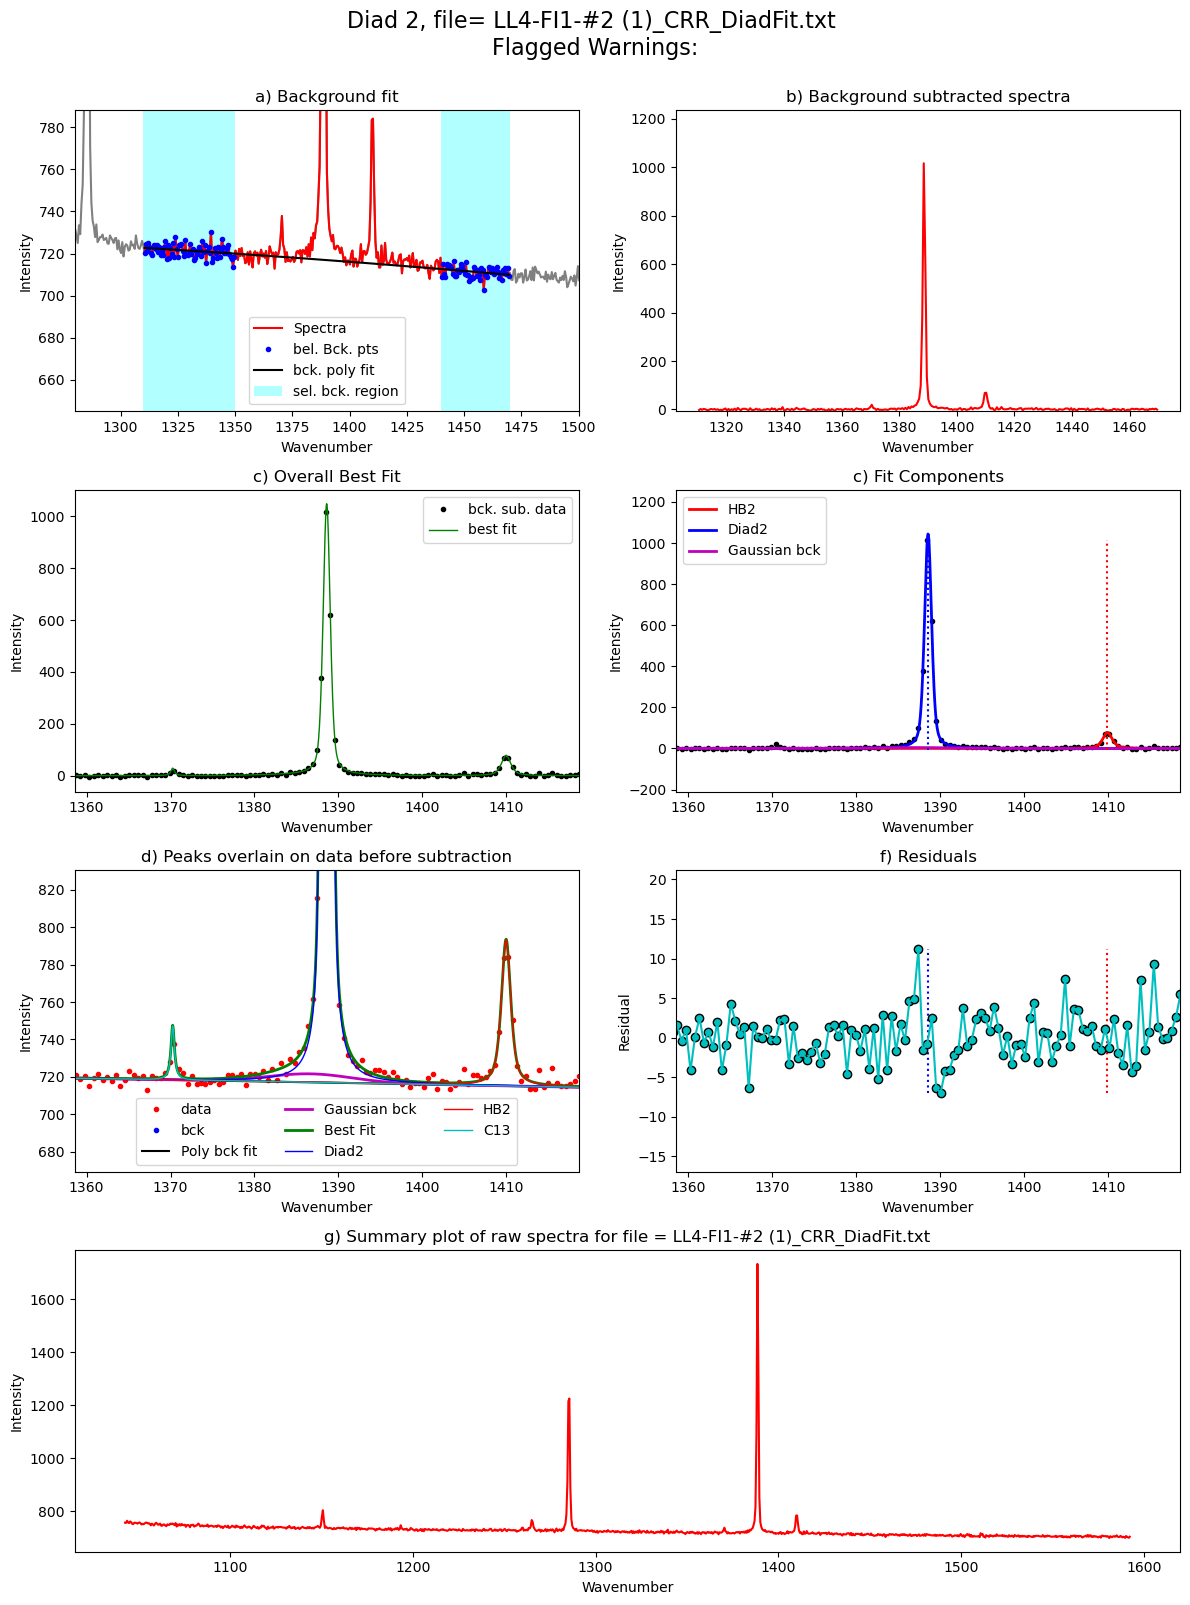

In [39]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=Diad_Files[i], filetype=filetype,
plot_figure=True, close_figure=False, 
Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
HB_pos=GroupN_df['HB2_pos'].iloc[i], 
C13_pos=GroupN_df['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

## Loop over all the files in the group
- This will loop over all the 

  0%|          | 0/5 [00:00<?, ?it/s]

Processing file: LL4-FI1-#2 (1)_CRR_DiadFit.txt


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Processing file: LL4-FI1-#2_CRR_DiadFit.txt


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

Processing file: LL7-107-FI#2_12mW1acc_CRR_DiadFit.txt


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

Processing file: LL7-107-FI#2_6mW_CRR_DiadFit.txt


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

Processing file: LL7-FI33_CRR_DiadFit.txt


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


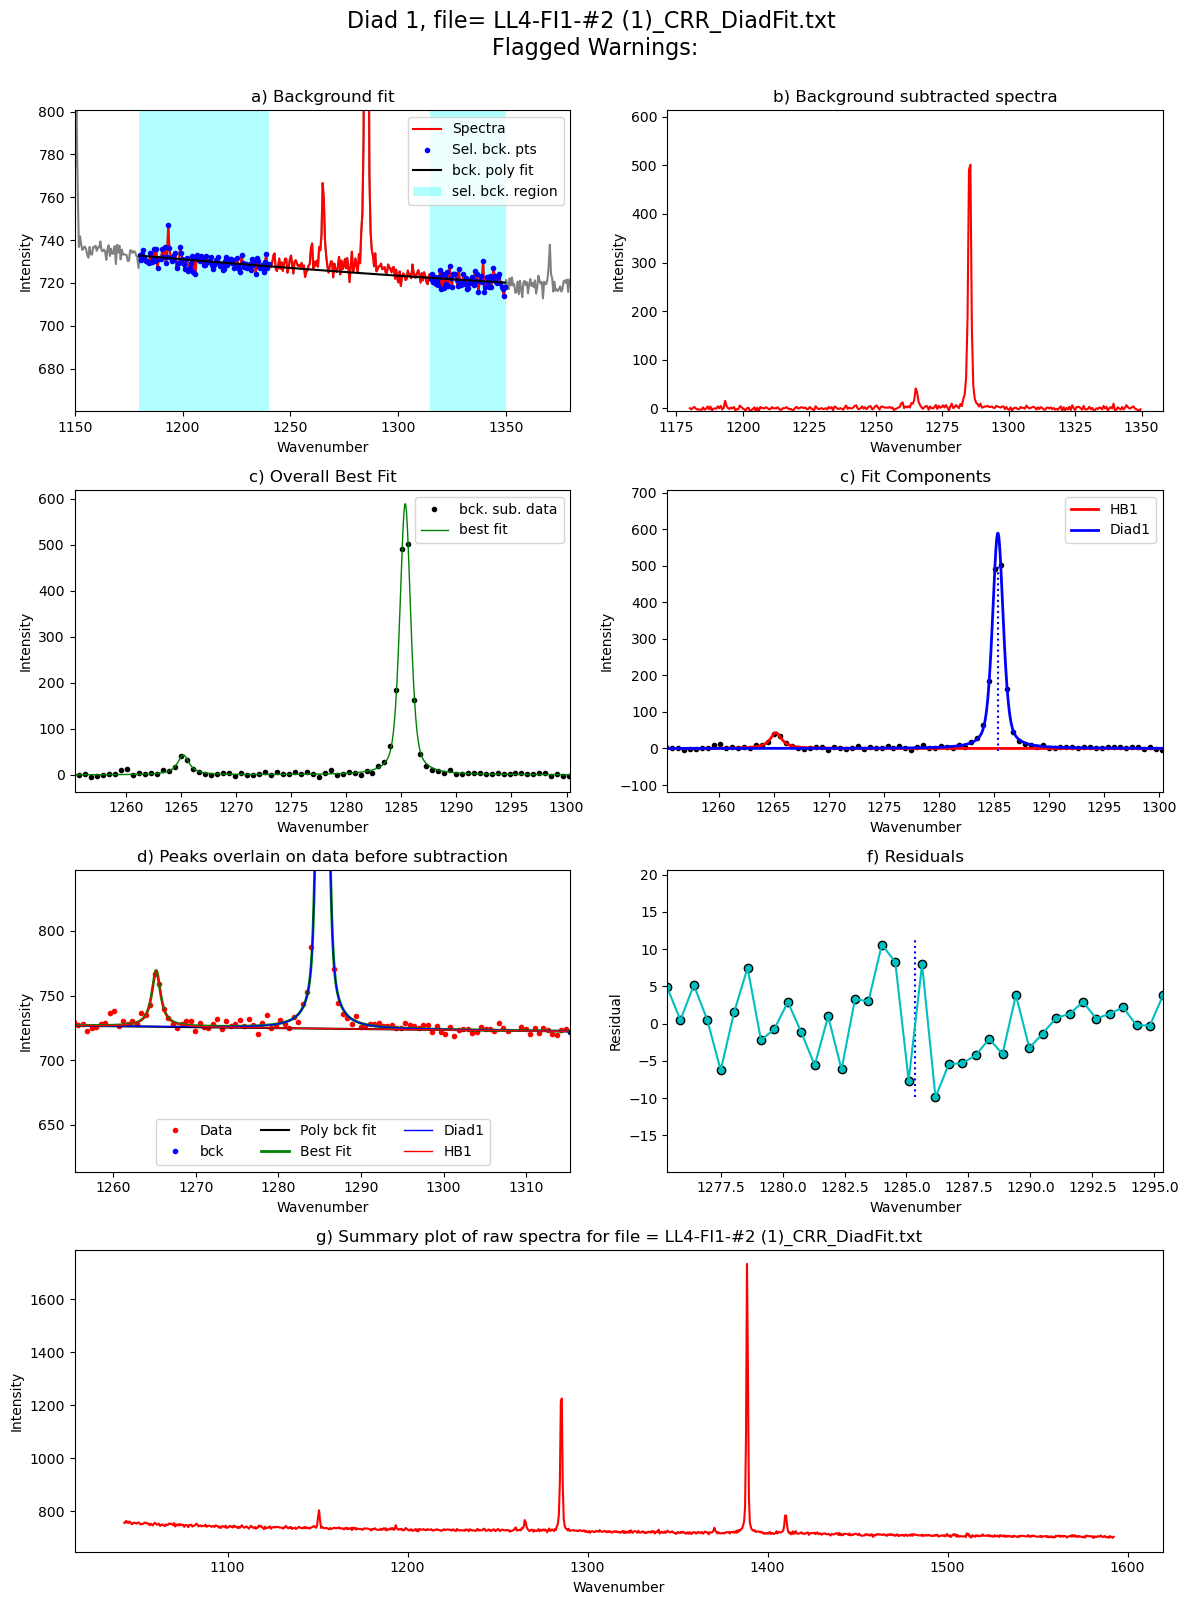

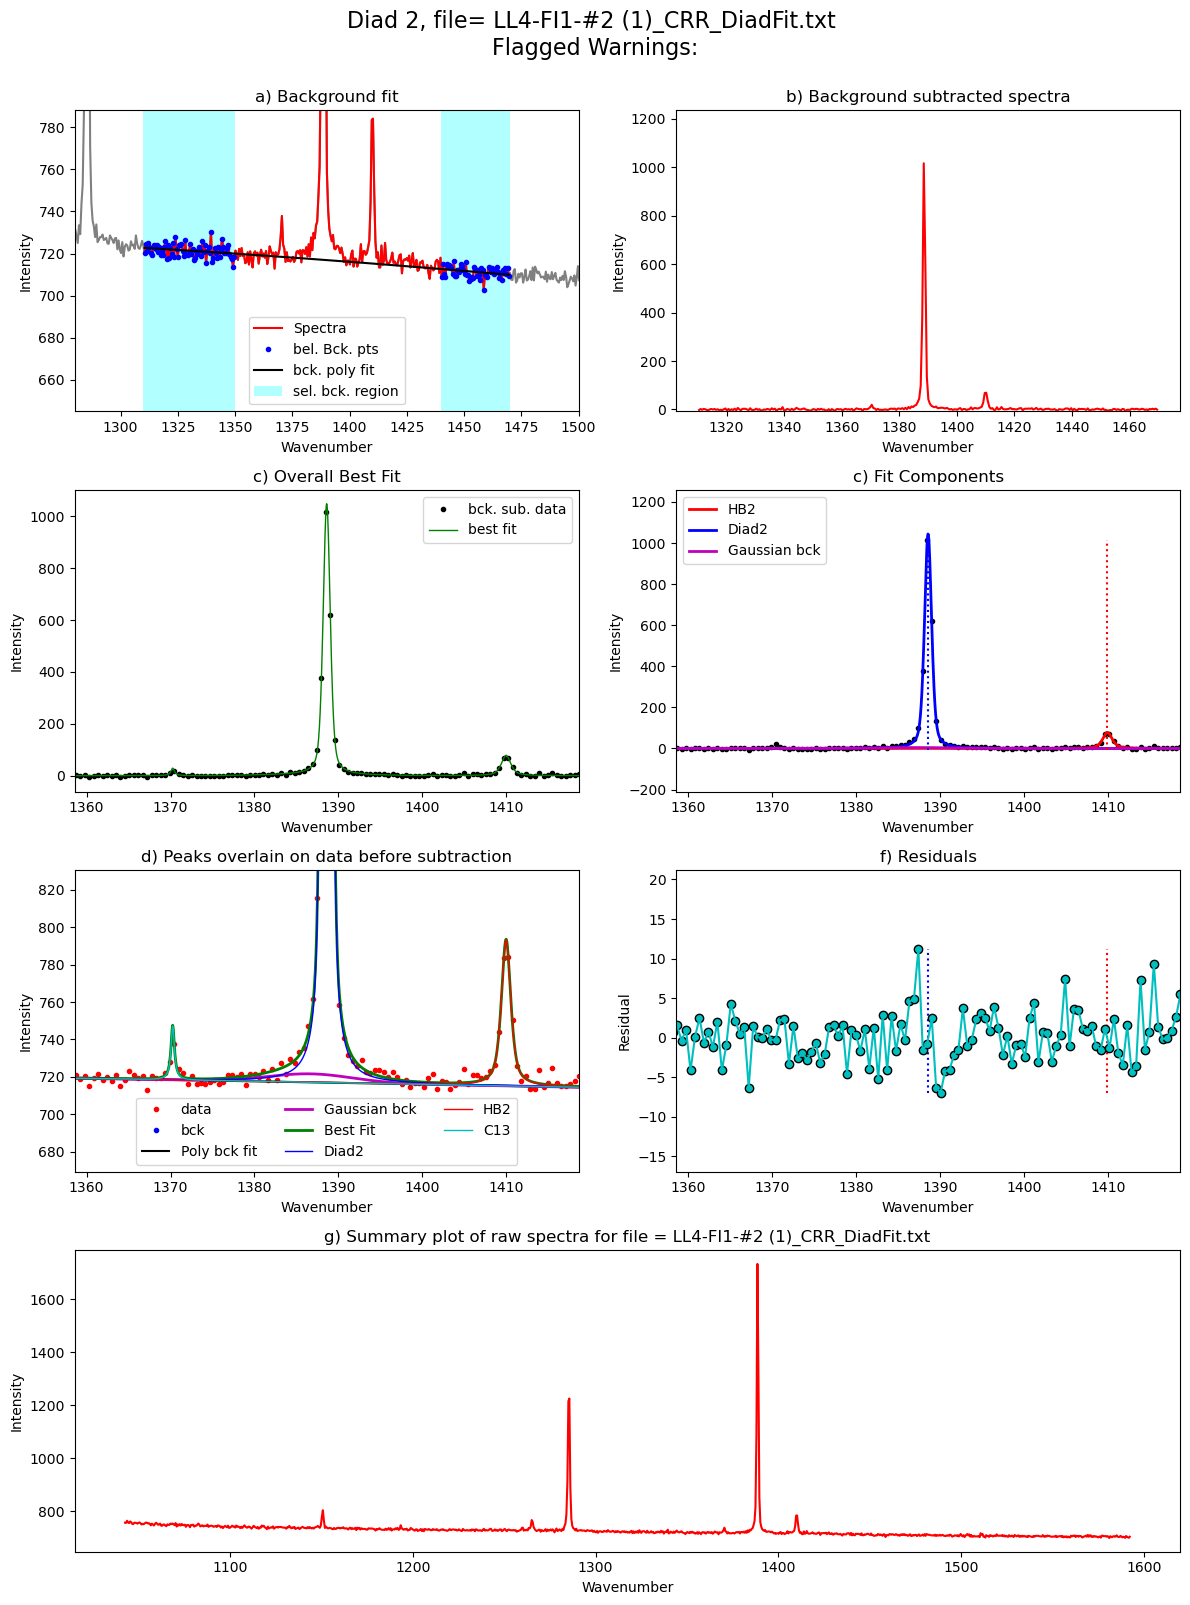

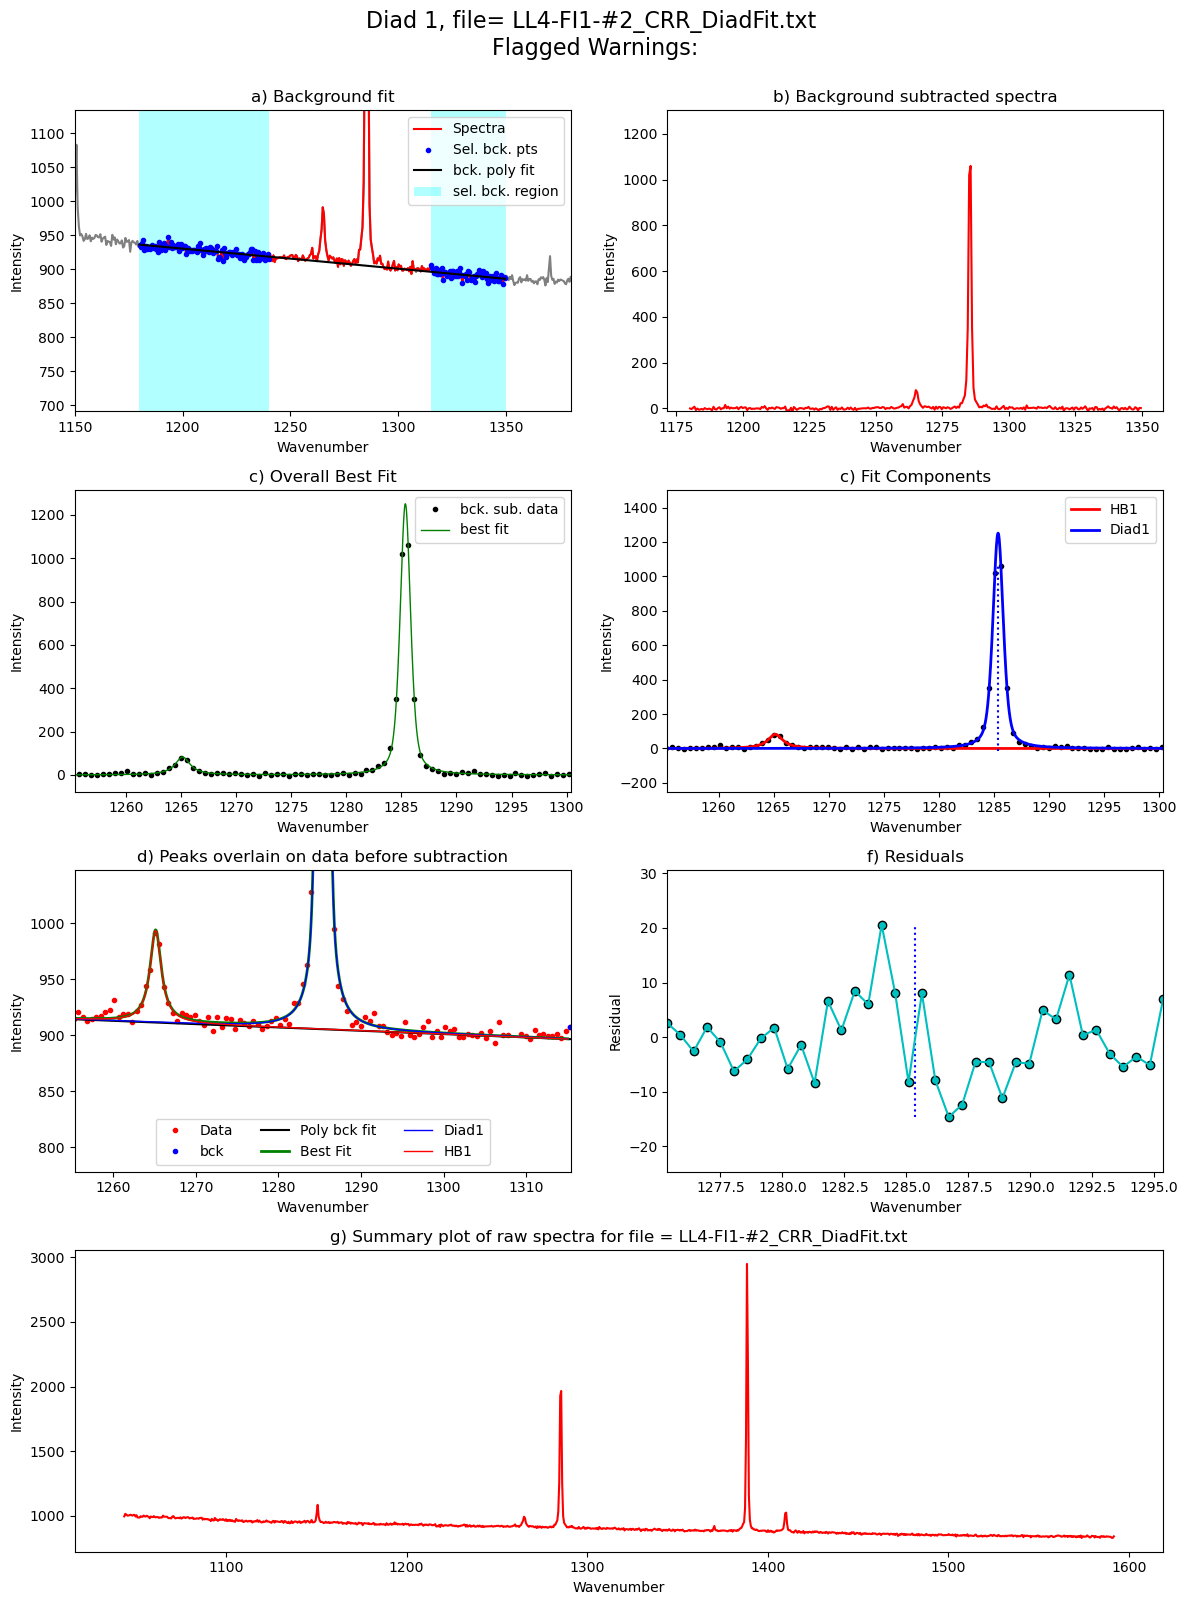

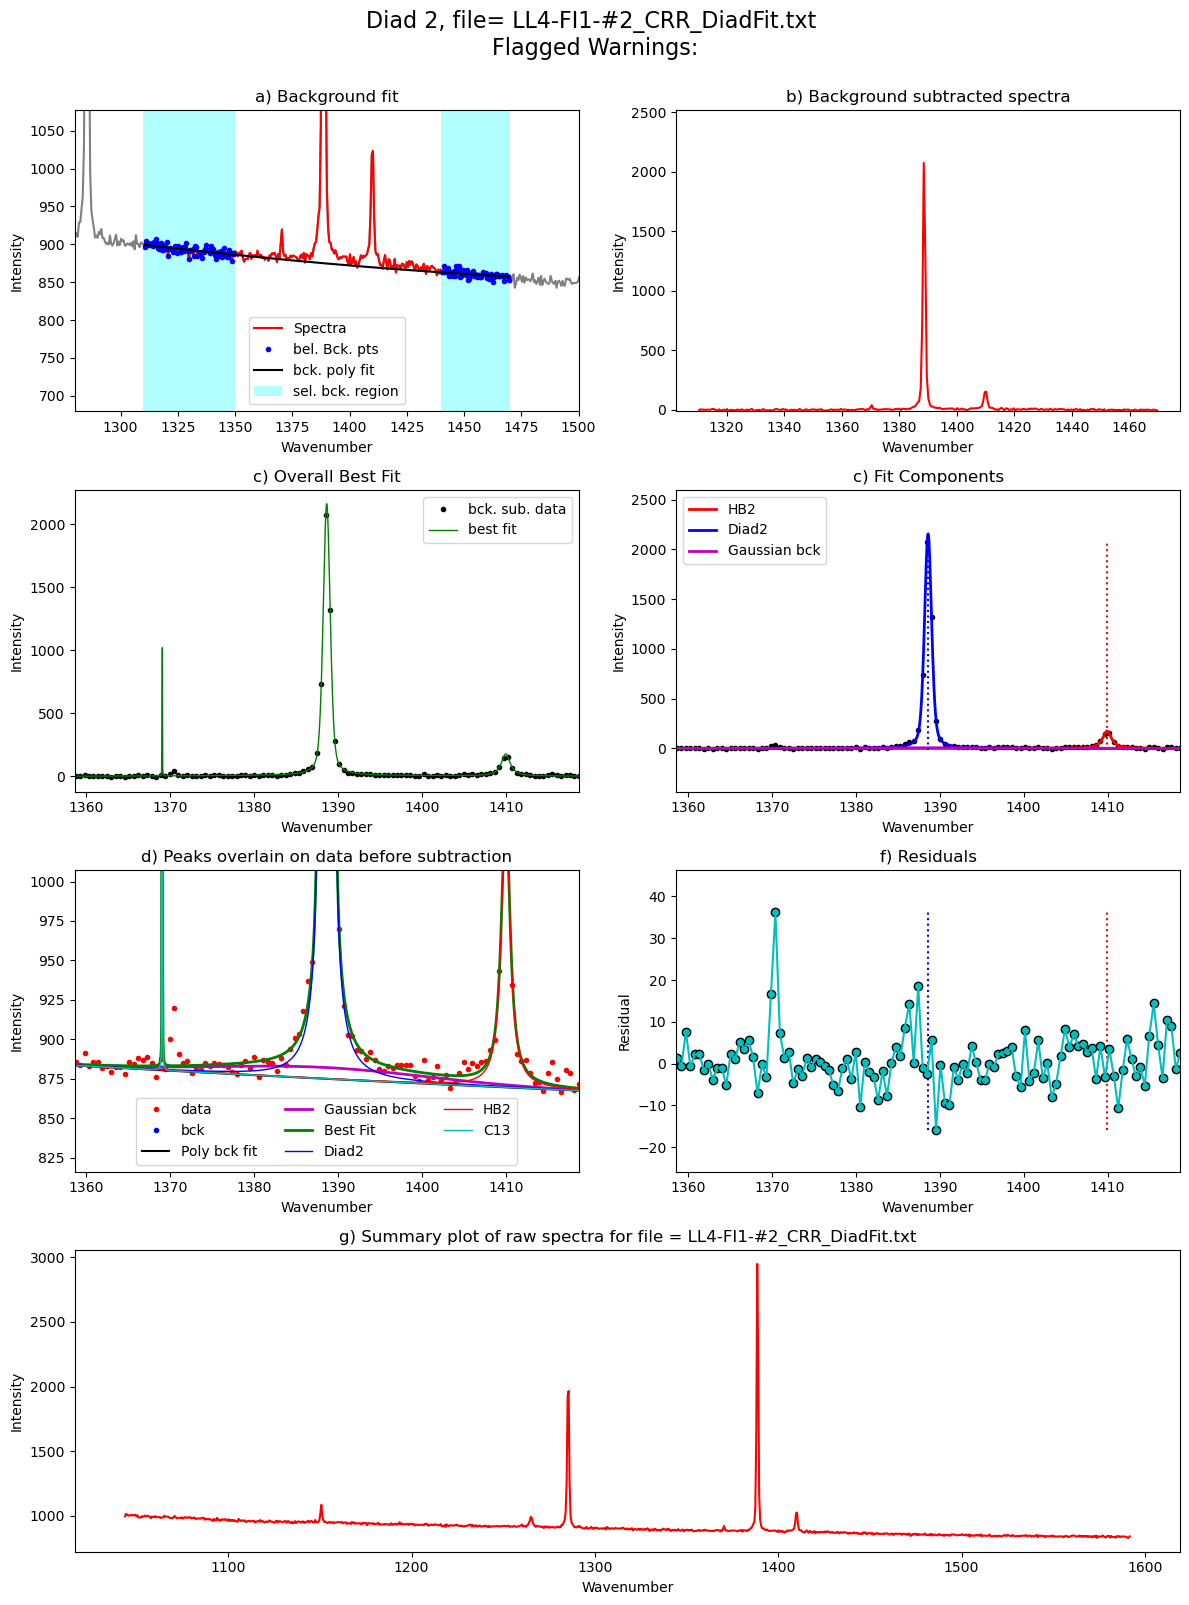

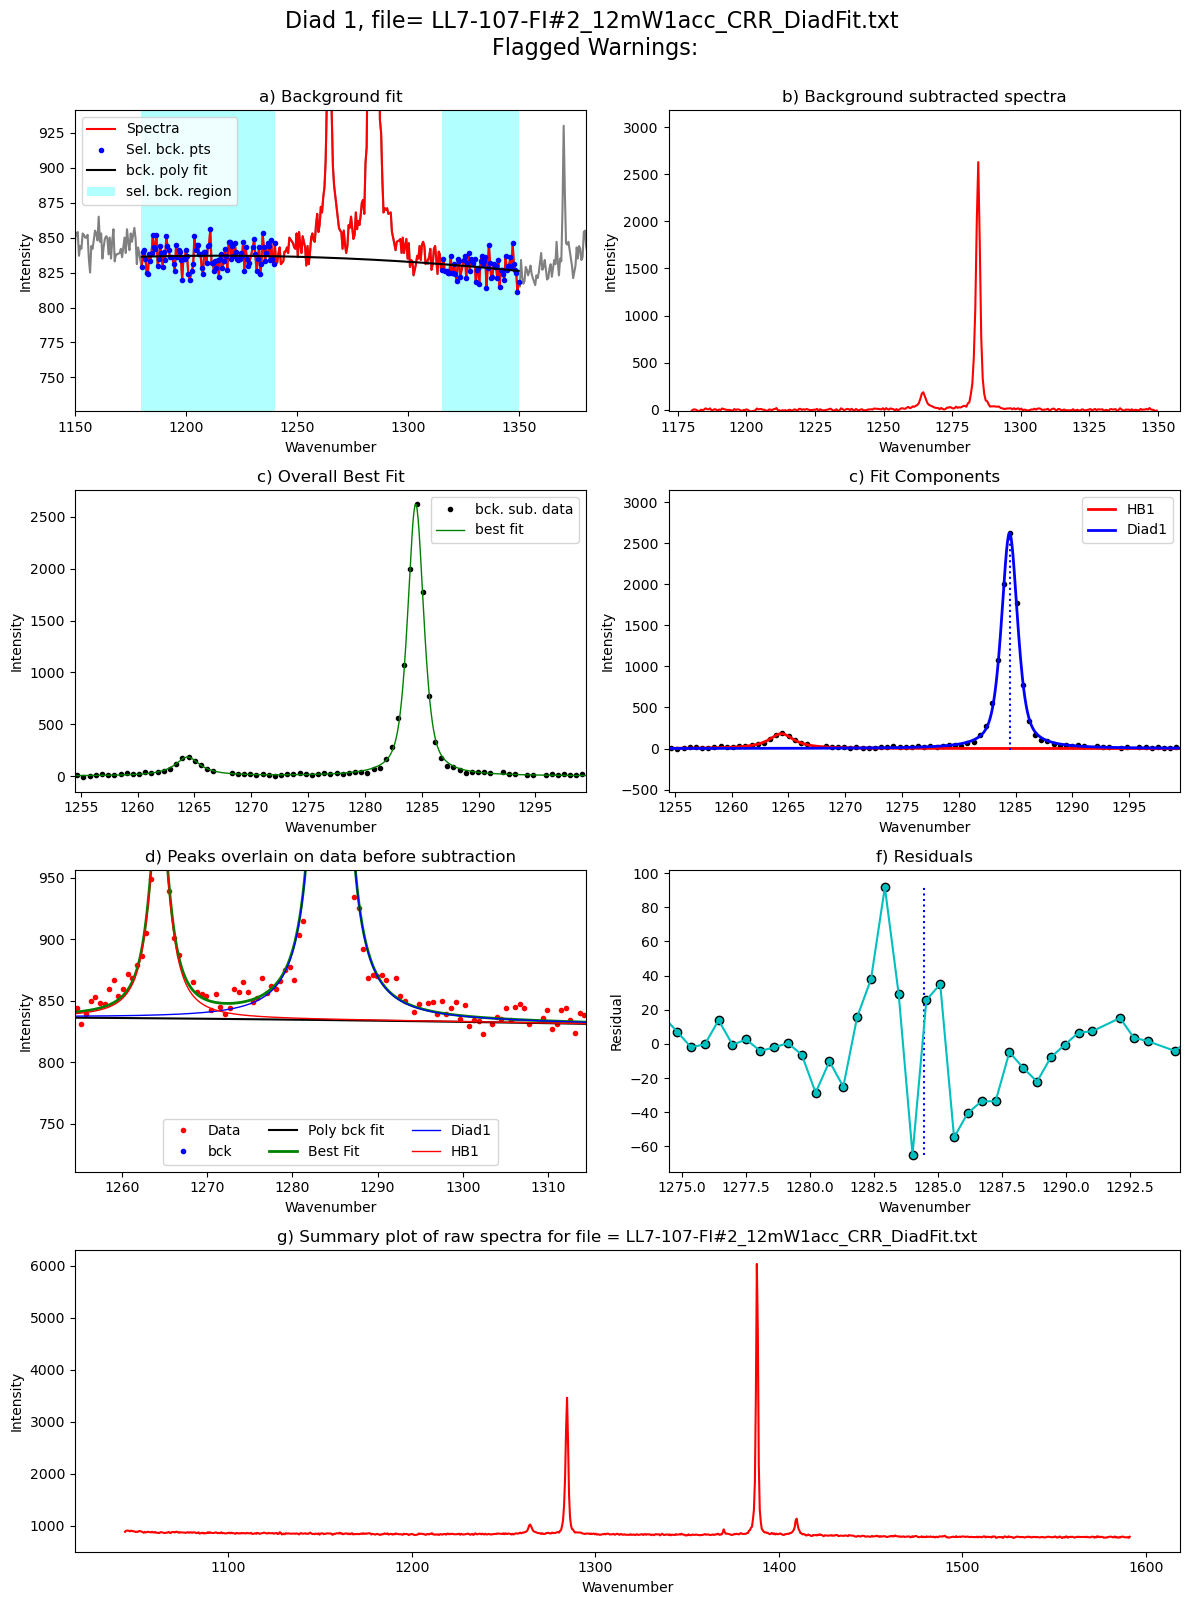

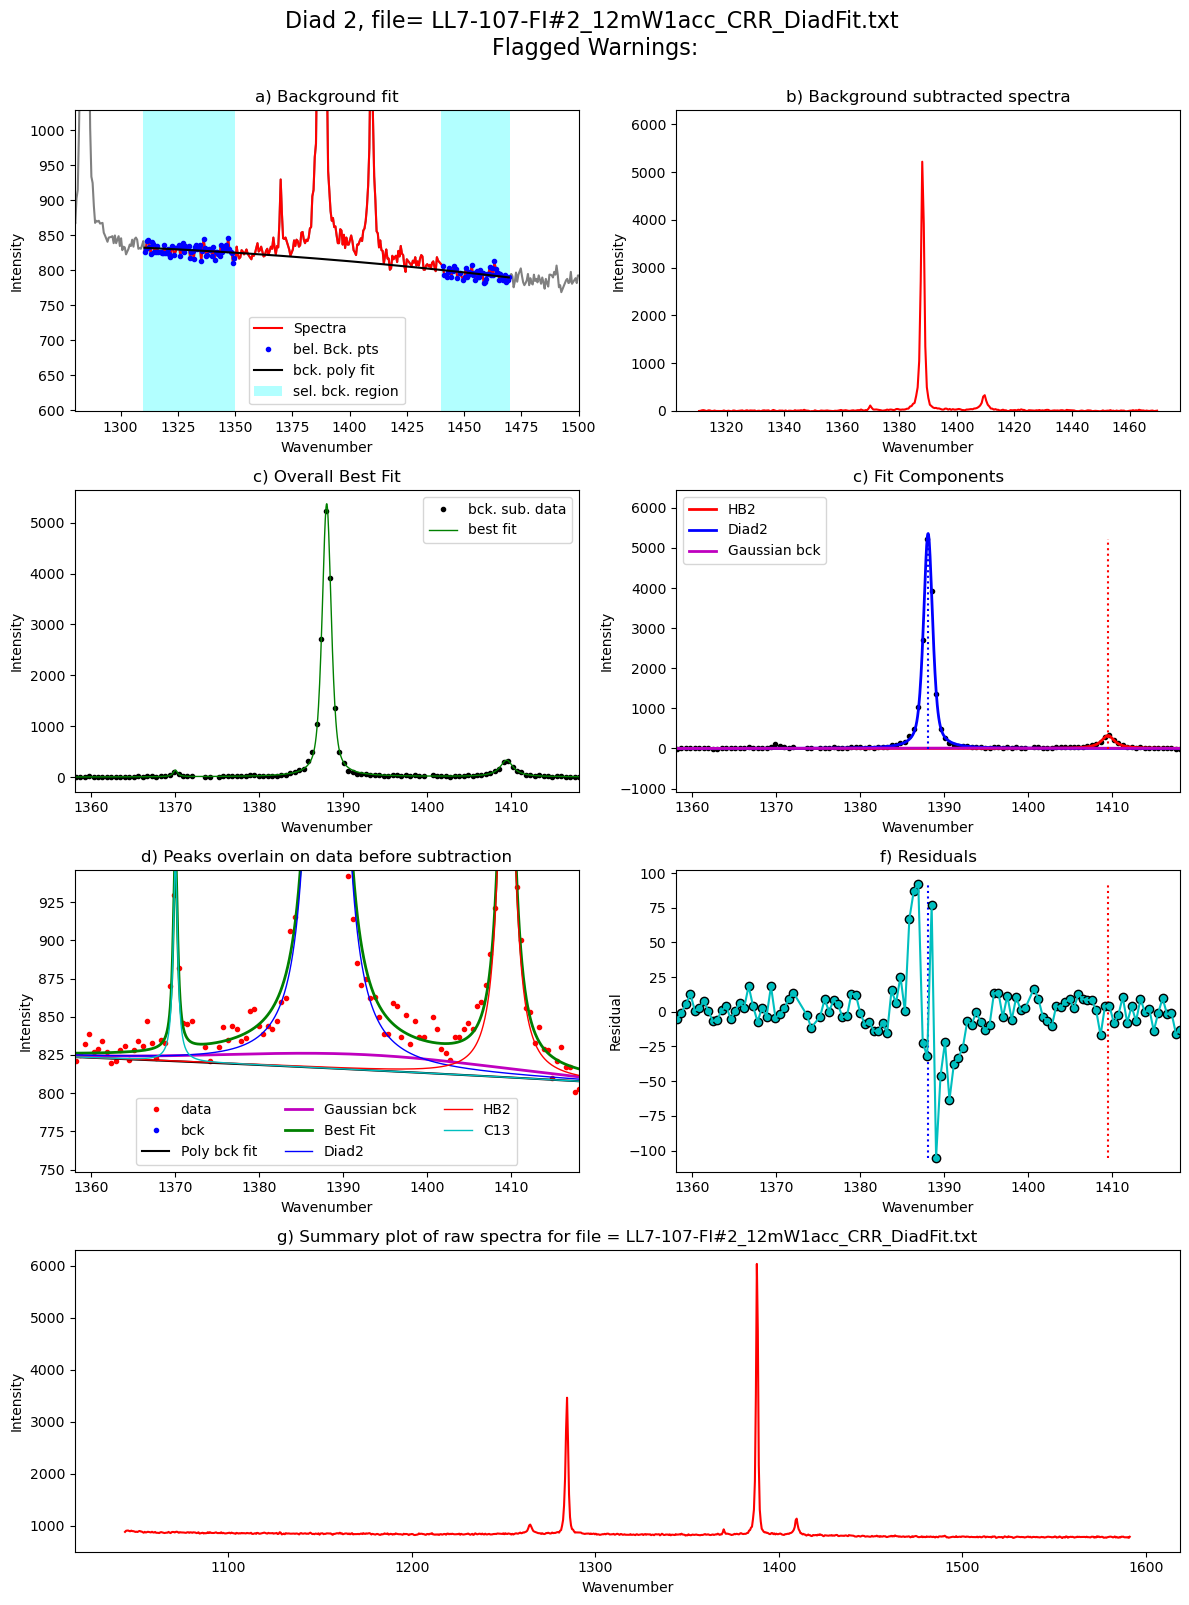

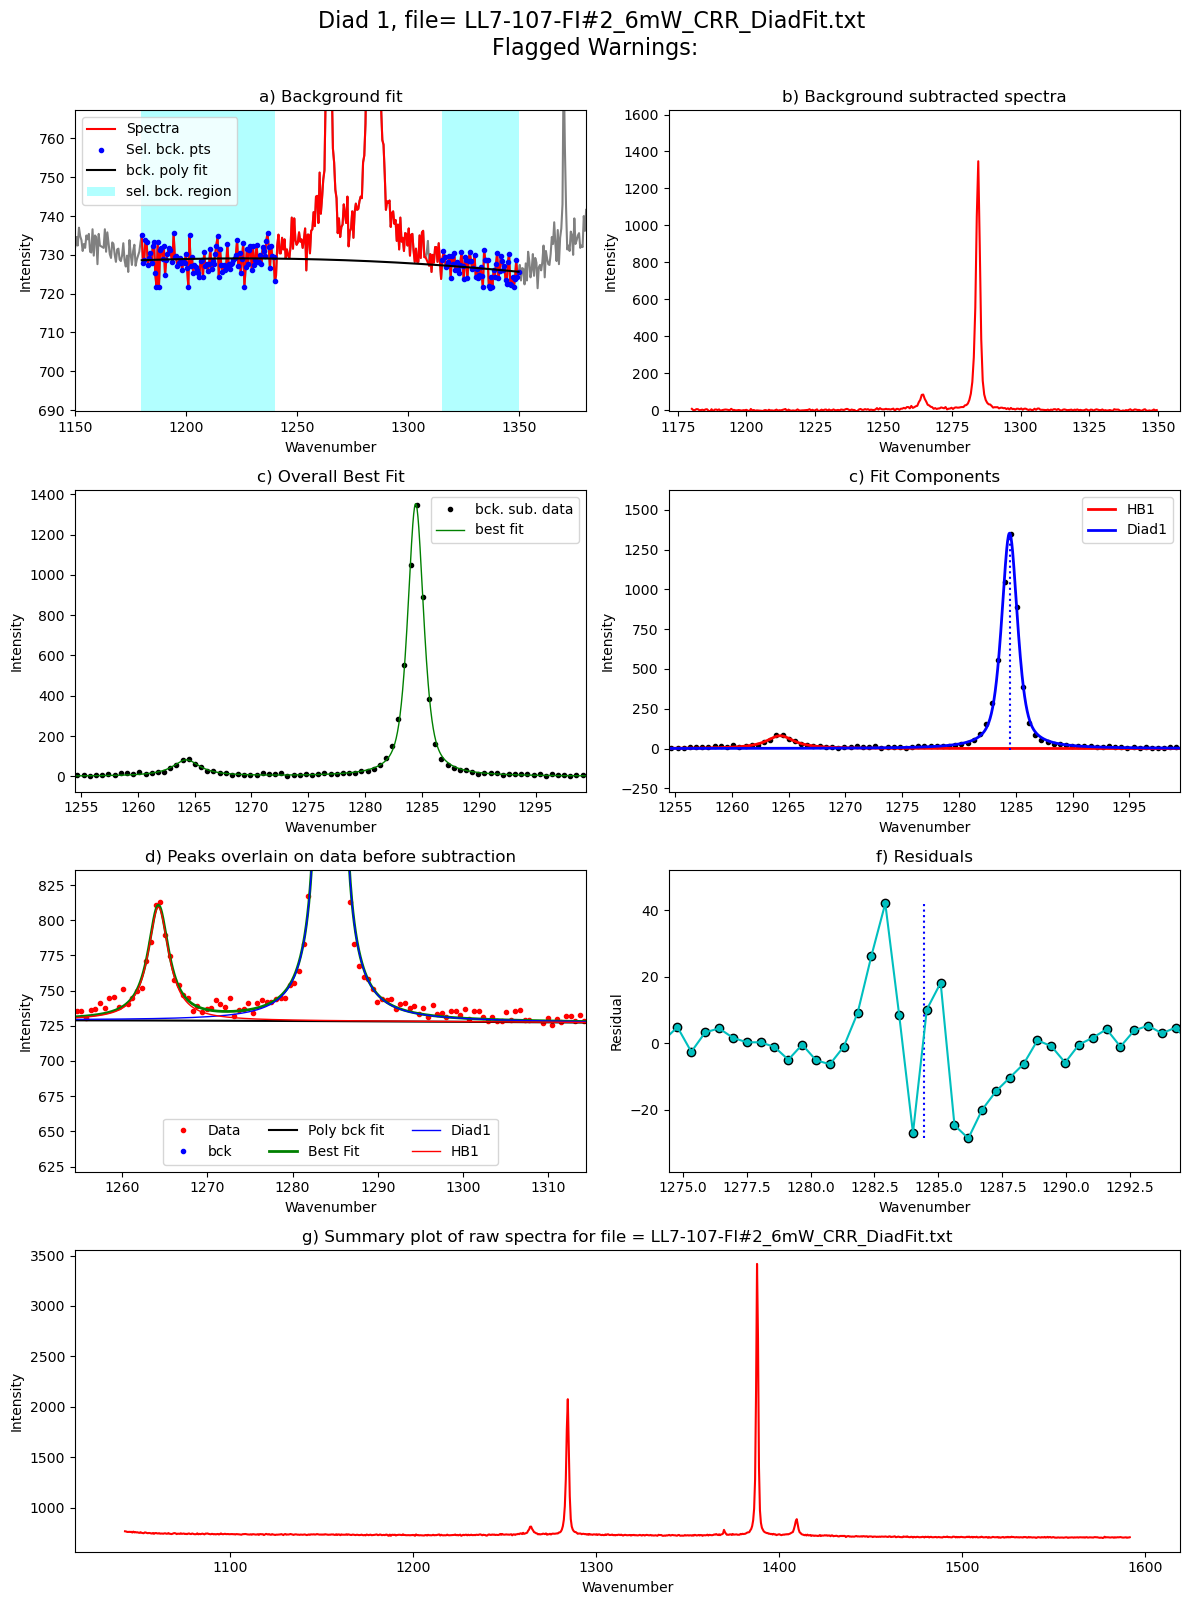

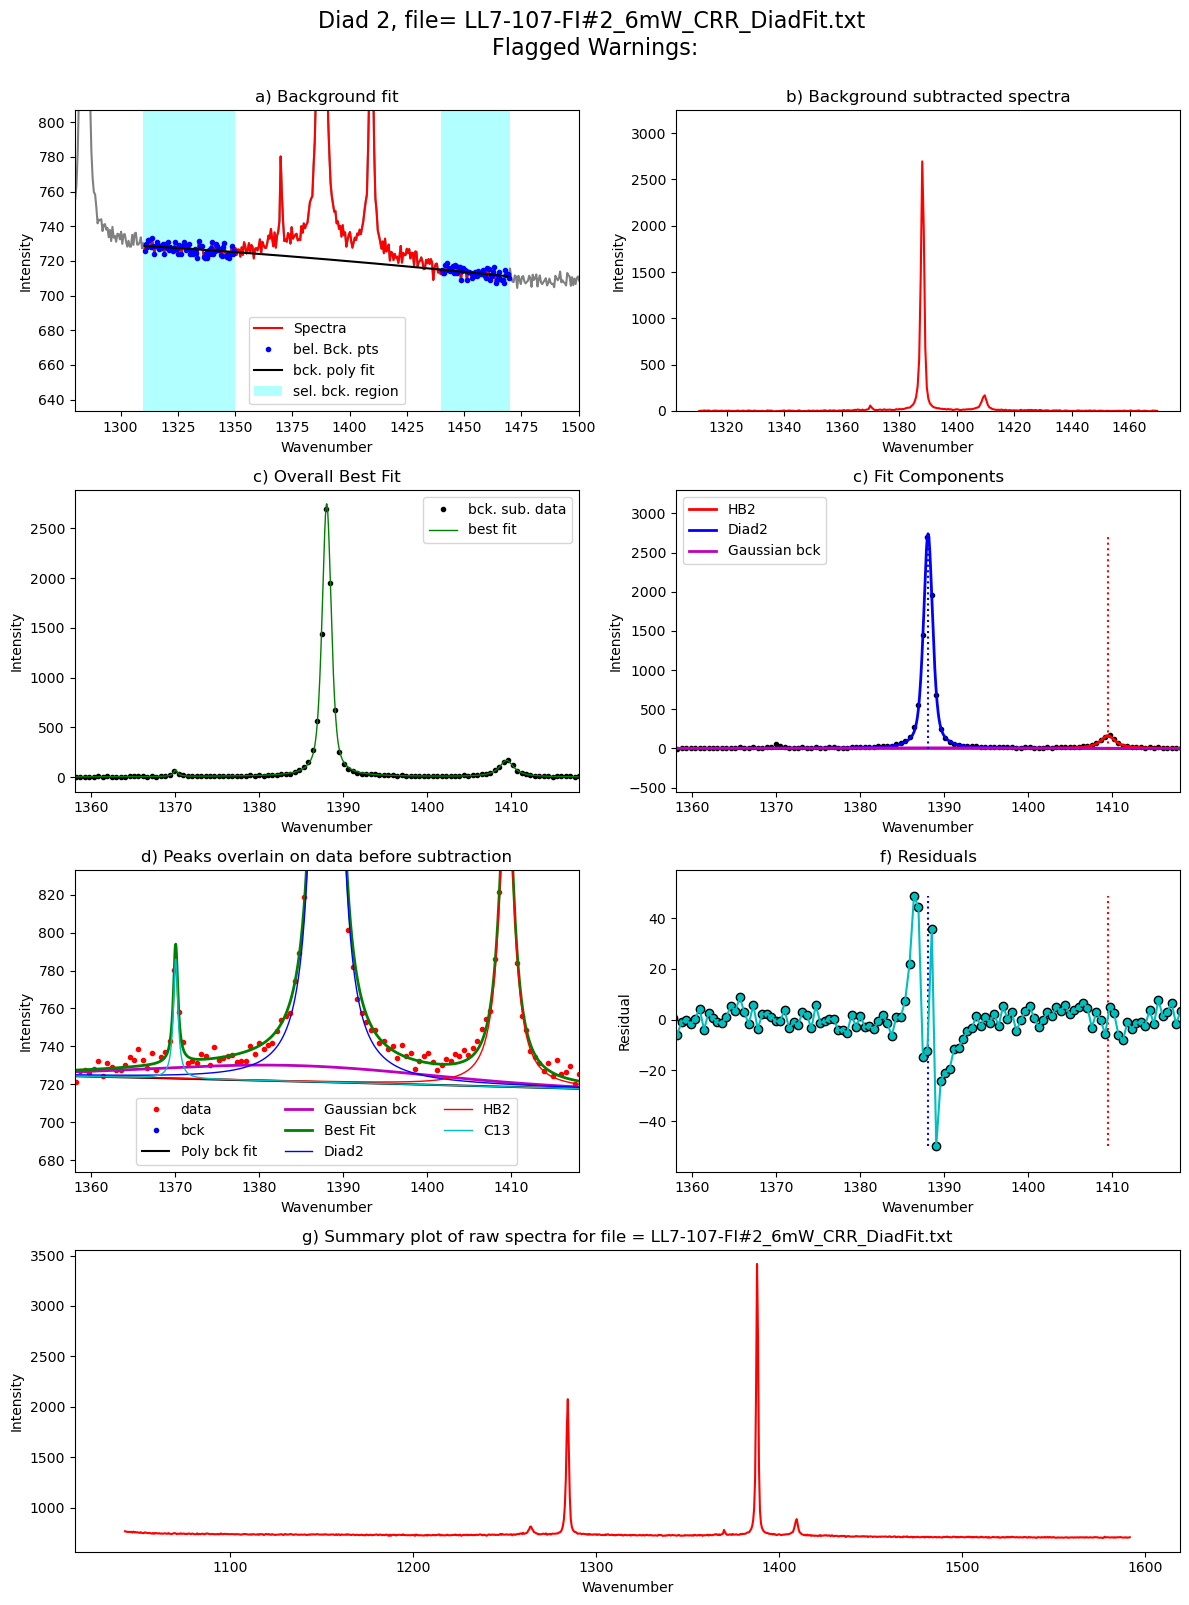

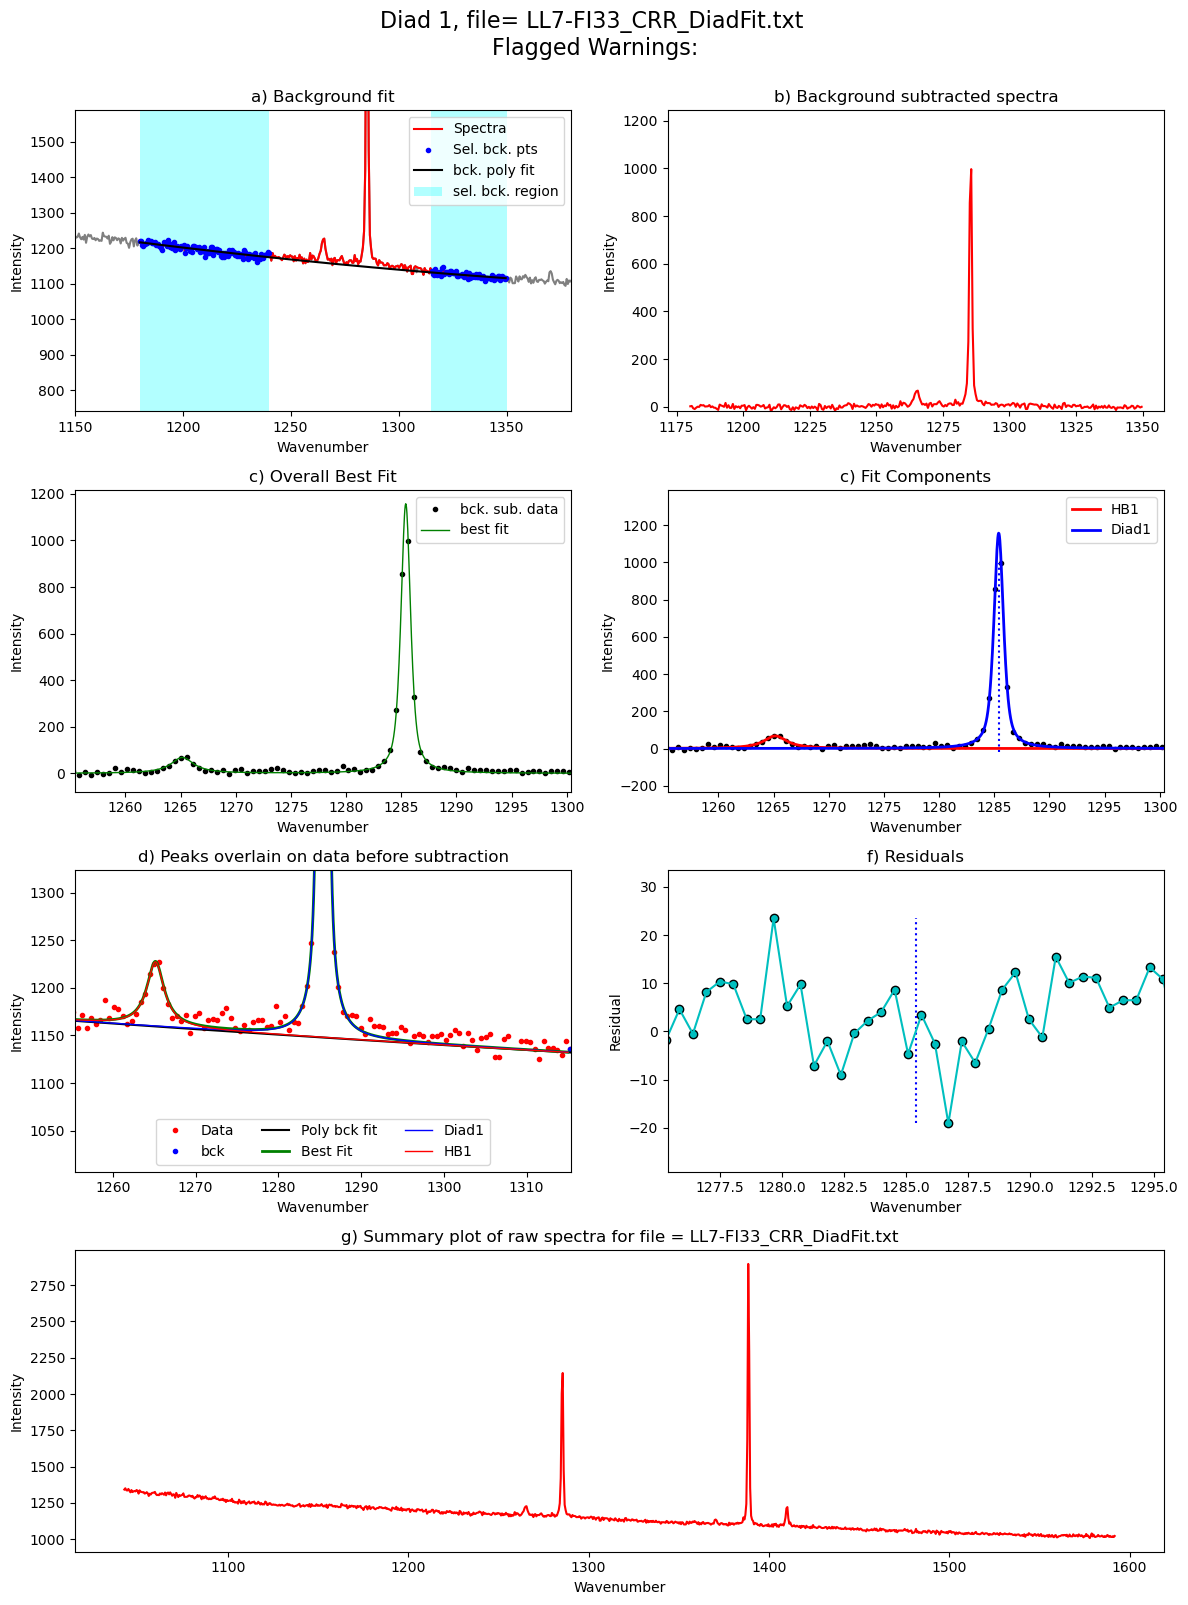

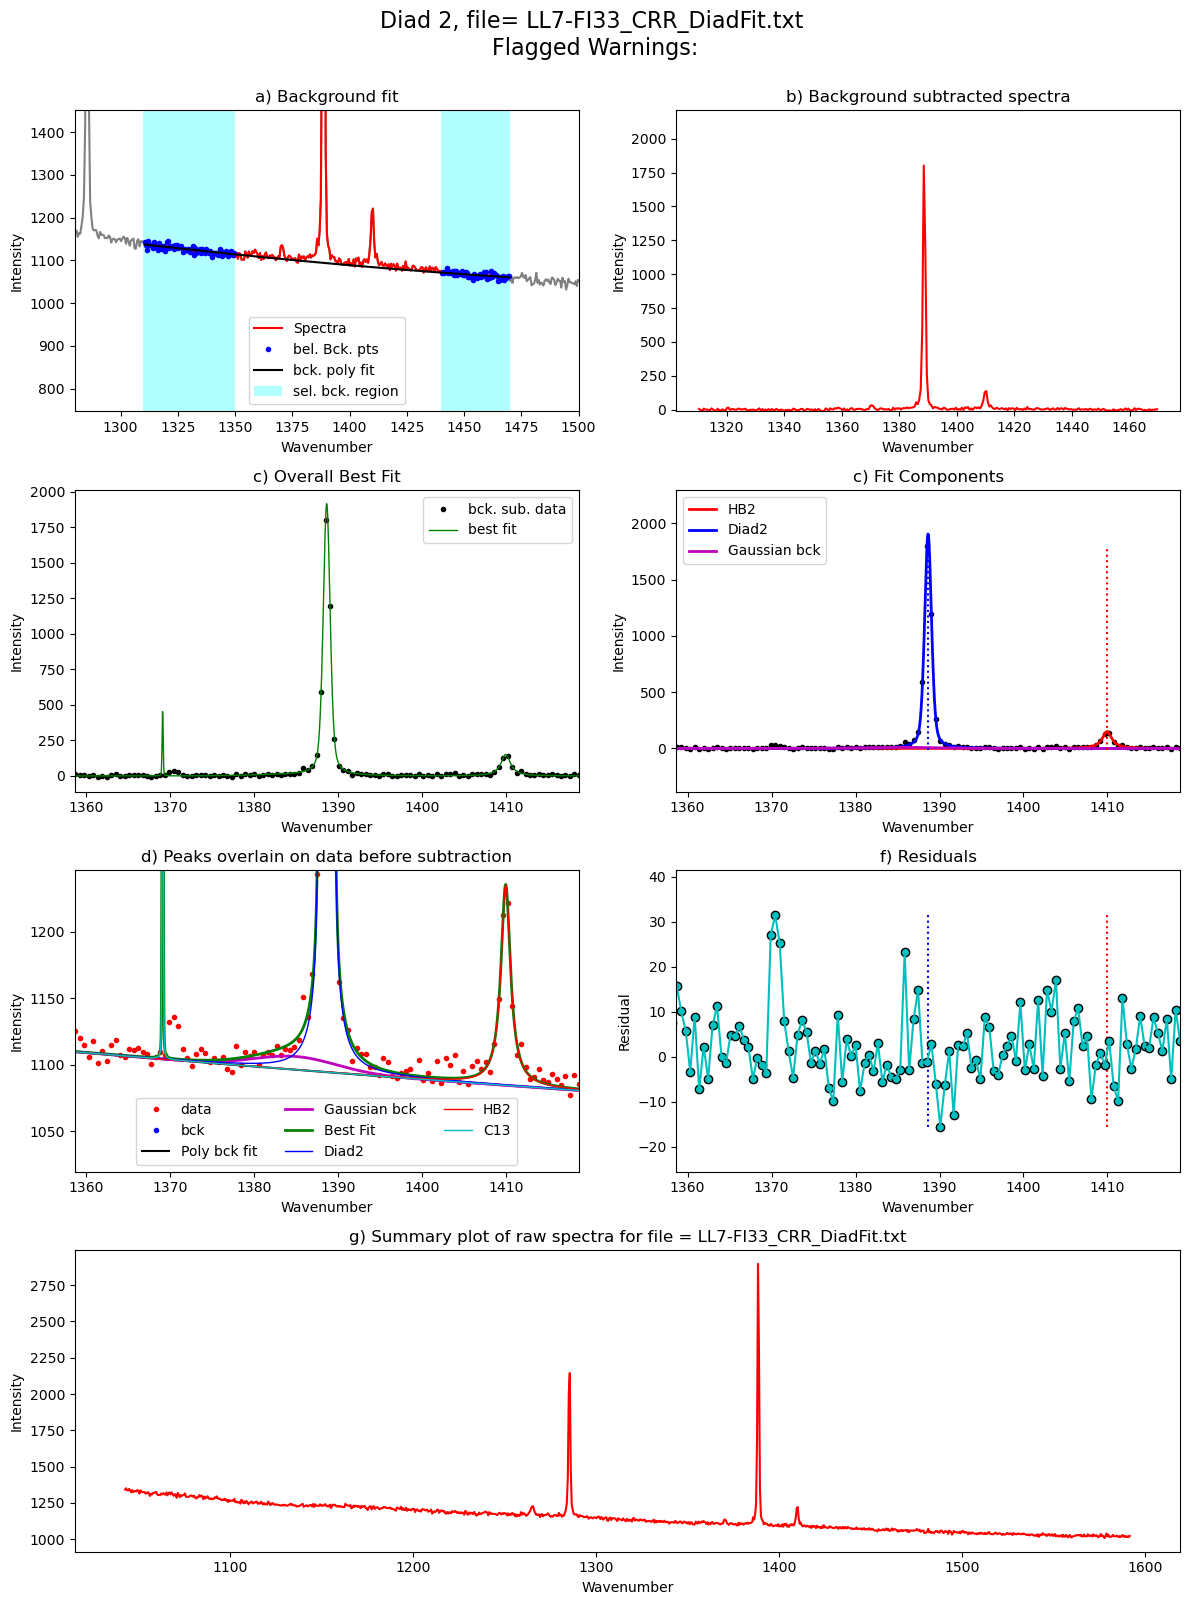

In [40]:
from tqdm import tqdm
plot_figure=True# If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    tqdm.write(f"Processing file: {Diad_Files[i]}")
    
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=GroupN_df['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*GroupN_df['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=GroupN_df['filename'].iloc[i],
    filetype=filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
    HB_pos=GroupN_df['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config_init.HB_prom=GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i]
    diad2_fit_config_init.gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.C13_prom=GroupN_df['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
        config2=diad_id_config,
    path=spectra_path, filename=GroupN_df['filename'].iloc[i], 
    filetype=filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
    HB_pos=GroupN_df['HB2_pos'].iloc[i], 
    C13_pos=GroupN_df['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=GroupN_df['filename'].iloc[i], prefix=prefix, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0).reset_index(drop=True)


In [41]:
# Save parameters to excel
combo=df_Merge

if batch=='Weak':
    combo.to_excel('Weak_Diads.xlsx', index=False)
if batch=='Medium':
    combo.to_excel('Medium_Diads.xlsx', index=False)
if batch=='Strong':
    combo.to_excel('Strong_Diads.xlsx', index=False)

In [42]:
combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma
0,LL4-FI1-#2 (1)_CRR_DiadFit,103.246459,0.003724,1285.353603,0.003350,589.621188,1285.353653,899.104347,0.580228,2.620155,...,0.666128,1370.261263,22.597890,0.249912,1386.657232,56.571588,4.998324,NaN,NaN,NaN
1,LL4-FI1-#2_CRR_DiadFit,103.249652,0.002209,1285.366511,0.001662,1251.487867,1285.366561,1851.724016,0.561267,3.917011,...,0.624481,1369.031629,72.376389,0.024826,1388.360298,221.845555,12.407912,NaN,NaN,NaN
2,LL7-107-FI#2_12mW1acc_CRR_DiadFit,103.611478,0.004263,1284.465823,0.003851,2622.947204,1284.465873,6051.475058,0.842049,9.579139,...,0.941211,1370.059389,131.935245,0.321128,1392.774405,403.780161,16.056494,NaN,NaN,NaN
3,LL7-107-FI#2_6mW_CRR_DiadFit,103.608926,0.003605,1284.448961,0.003236,1353.210453,1284.449011,3115.219299,0.833280,4.692185,...,1.051871,1370.069481,64.085792,0.323394,1383.924543,339.513132,16.169892,NaN,NaN,NaN
4,LL7-FI33_CRR_DiadFit,103.231516,0.004153,1285.405937,0.003604,1158.042021,1285.405987,1682.909181,0.520985,6.829009,...,0.689307,1369.101793,79.810815,0.074380,1384.937322,122.035198,4.872154,NaN,NaN,NaN
